In [ ]:
# Optimized Offline LSTM Autoencoder for Anomaly Detection (Keras-based)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_offline"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 30
EPOCHS = 5
BATCH_SIZE = 32
LATENT_DIM = 32
CONTAMINATION = 0.05
MAX_TRAIN_LEN = 2000

In [2]:
# Helper: Create sliding windows
def create_sequences(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])

# Build LSTM Autoencoder
def build_model(window_size, latent_dim):
    input_layer = Input(shape=(window_size, 1))
    encoded = LSTM(latent_dim, activation='relu')(input_layer)
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(latent_dim, activation='relu', return_sequences=True)(decoded)
    output = TimeDistributed(Dense(1))(decoded)
    return Model(inputs=input_layer, outputs=output)

# Run model per time series
def run_lstm_autoencoder(ts):
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.reshape(-1, 1)).flatten()

    X = create_sequences(ts_scaled, WINDOW_SIZE)
    X = X.reshape(-1, WINDOW_SIZE, 1)

    # Limit training data to speed up
    X_train = X[:min(MAX_TRAIN_LEN, len(X))]

    model = build_model(WINDOW_SIZE, LATENT_DIM)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    X_pred = model.predict(X, batch_size=BATCH_SIZE, verbose=0)
    errors = np.mean(np.square(X - X_pred), axis=(1, 2))
    return errors



Processing normality_1_daphnet.npy
Precision: 0.389, Recall: 0.171, F1: 0.237, AUC: 0.741, Time: 114.39s


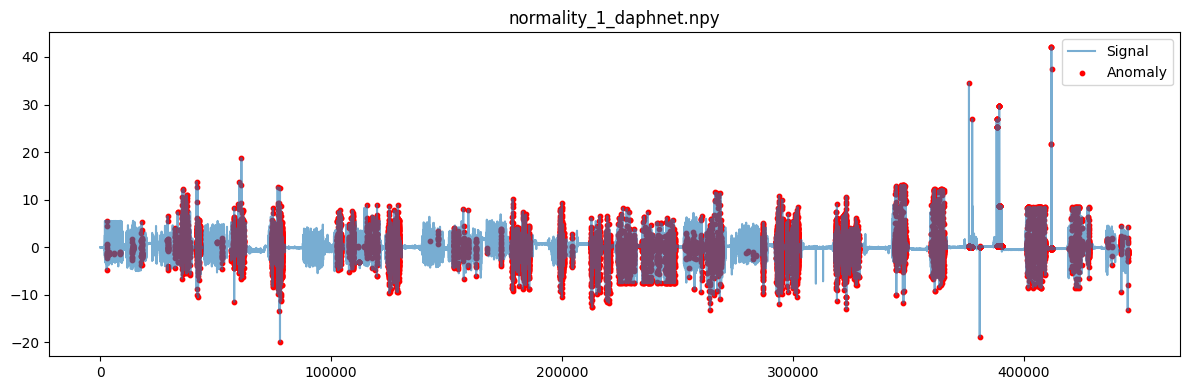


Processing normality_1_genesis.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.724, Time: 21.51s


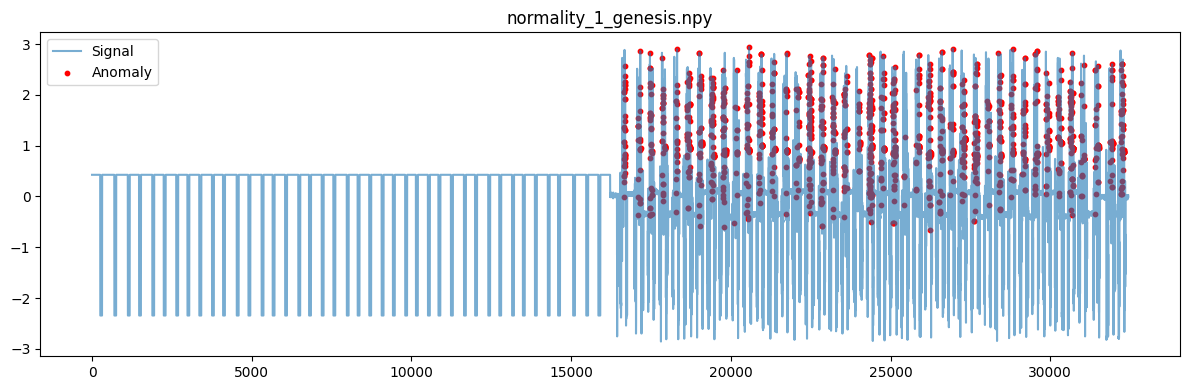


Processing normality_1_nasa-msl.npy
Precision: 0.257, Recall: 0.209, F1: 0.231, AUC: 0.777, Time: 36.84s


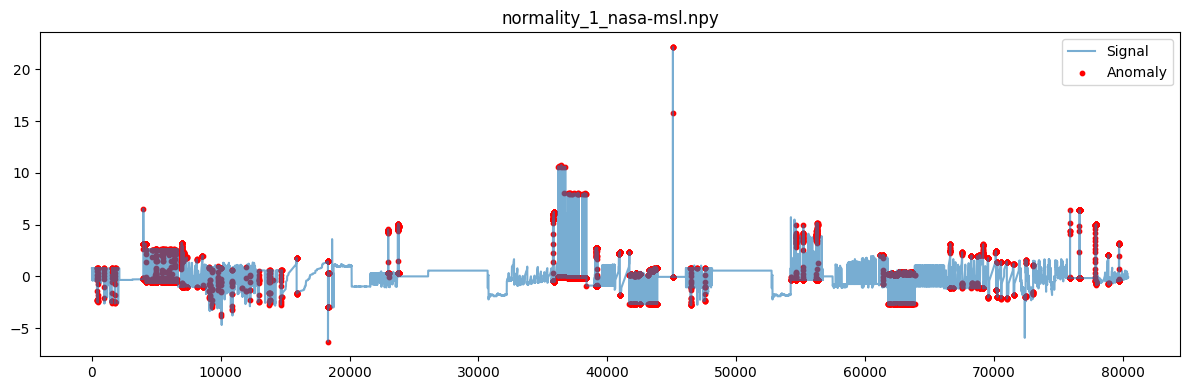


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.381, Recall: 0.180, F1: 0.244, AUC: 0.736, Time: 139.23s


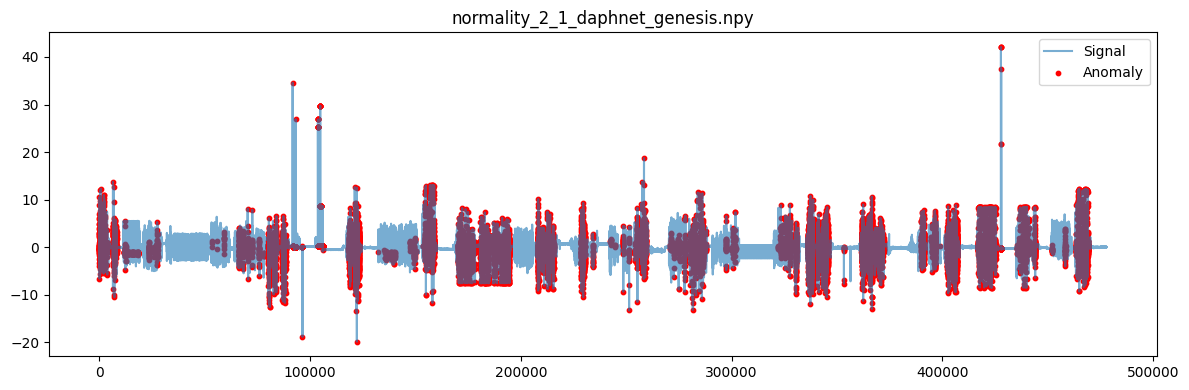


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.374, Recall: 0.177, F1: 0.240, AUC: 0.717, Time: 146.62s


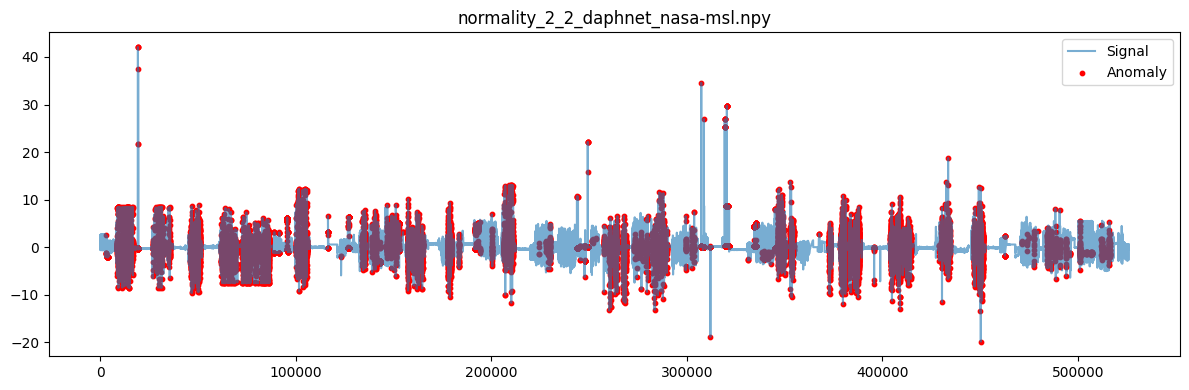


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.160, Recall: 0.179, F1: 0.169, AUC: 0.726, Time: 43.94s


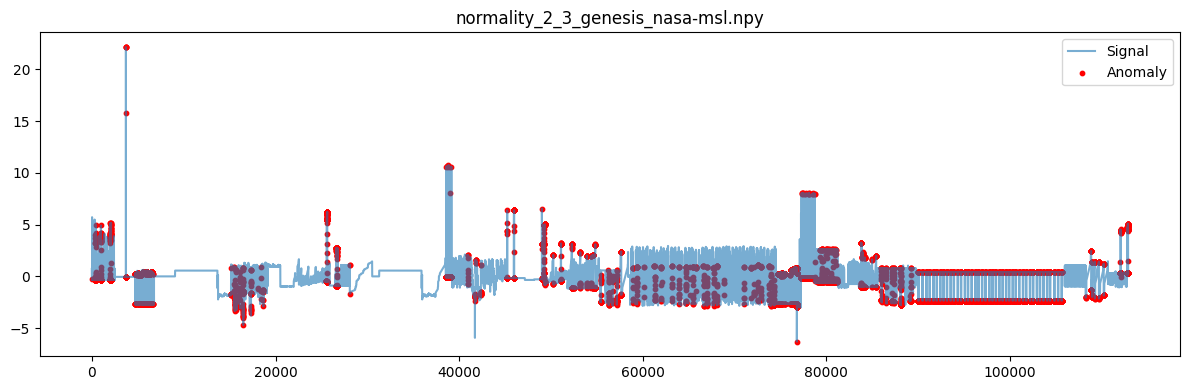


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.371, Recall: 0.186, F1: 0.248, AUC: 0.750, Time: 156.58s


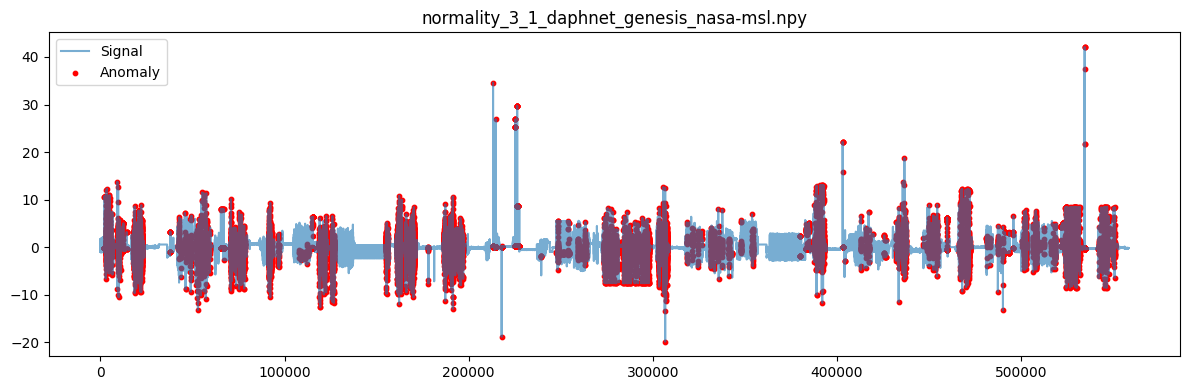


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.369, Recall: 0.185, F1: 0.247, AUC: 0.737, Time: 164.15s


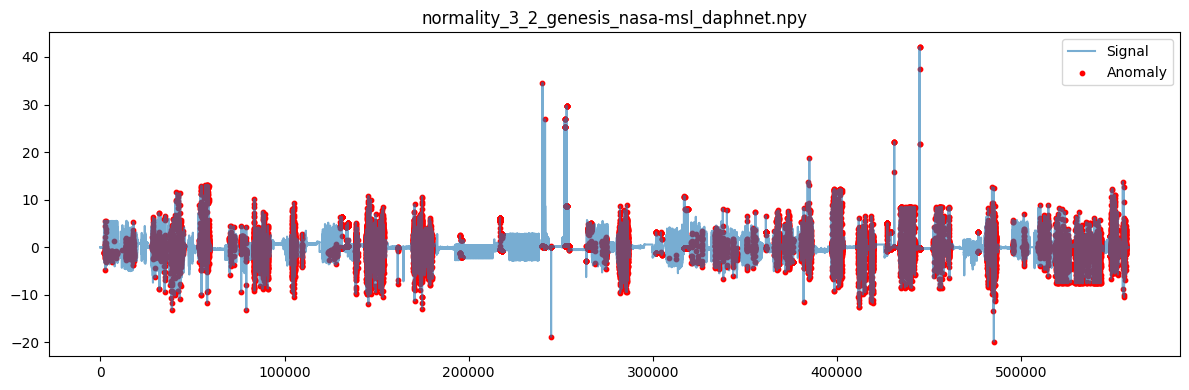


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.371, Recall: 0.186, F1: 0.248, AUC: 0.757, Time: 149.03s


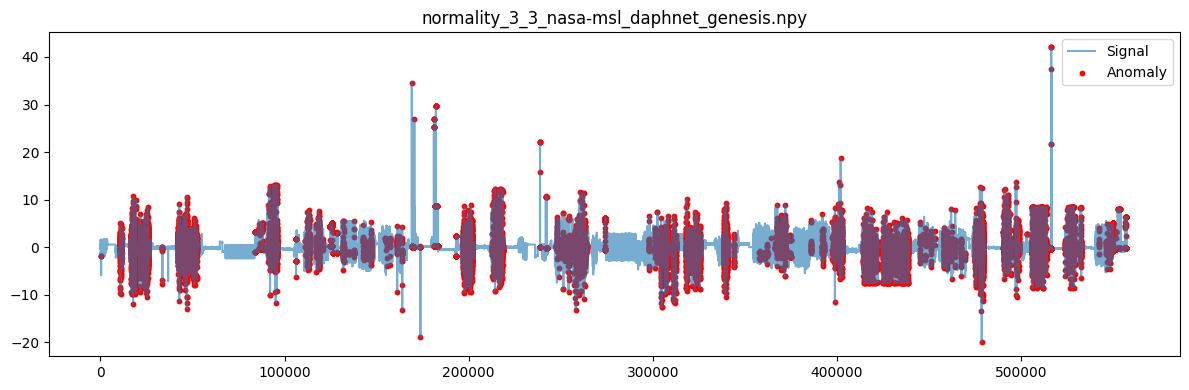

In [3]:
# Summary list
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_labels" in fname or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts_path = os.path.join(DATA_DIR, fname)
    label_path = ts_path.replace(".npy", "_labels.npy")

    if not os.path.exists(label_path):
        print(f"Skipping {fname}, missing labels.")
        continue

    ts = np.load(ts_path)
    labels = np.load(label_path)

    try:
        start = time.time()
        scores = run_lstm_autoencoder(ts)
        threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
        preds = (scores > threshold).astype(int)
        y_true = labels[WINDOW_SIZE:]

        p = precision_score(y_true, preds, zero_division=0)
        r = recall_score(y_true, preds, zero_division=0)
        f = f1_score(y_true, preds, zero_division=0)
        a = roc_auc_score(y_true, scores) if len(set(y_true)) > 1 else 0.0
        t = round(time.time() - start, 2)

        print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}, Time: {t}s")

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(ts, label="Signal", alpha=0.6)
        anomaly_idxs = np.where(preds == 1)[0] + WINDOW_SIZE // 2
        anomaly_idxs = anomaly_idxs[anomaly_idxs < len(ts)]
        plt.scatter(anomaly_idxs, ts[anomaly_idxs], color='red', s=10, label="Anomaly")
        plt.title(fname)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, fname.replace(".npy", ".png")))
        plt.show()
        plt.close()

        summary.append(dict(dataset=fname, length=len(ts),
                            precision=round(p, 3),
                            recall=round(r, 3),
                            f1=round(f, 3),
                            auc=round(a, 3),
                            time=t))

    except Exception as e:
        print(f"Skipped {fname} due to error: {e}")

In [4]:
# Save summary
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "lstm_offline_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc,time
dataset,,,,,,
normality_1_daphnet.npy,445440,0.389,0.171,0.237,0.741,114.39
normality_1_genesis.npy,32440,0.000,0.000,0.000,0.724,21.51
normality_1_nasa-msl.npy,80427,0.257,0.209,0.231,0.777,36.84
normality_2_1_daphnet_genesis.npy,477880,0.381,0.180,0.244,0.736,139.23
normality_2_2_daphnet_nasa-msl.npy,525867,0.374,0.177,0.240,0.717,146.62
normality_2_3_genesis_nasa-msl.npy,112867,0.160,0.179,0.169,0.726,43.94
normality_3_1_daphnet_genesis_nasa-msl.npy,558307,0.371,0.186,0.248,0.750,156.58
normality_3_2_genesis_nasa-msl_daphnet.npy,558307,0.369,0.185,0.247,0.737,164.15
normality_3_3_nasa-msl_daphnet_genesis.npy,558307,0.371,0.186,0.248,0.757,149.03
